In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import json

In [4]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

DATA_DIR    = os.path.join(PROJECT_ROOT, "data")
MODELS_DIR  = os.path.join(PROJECT_ROOT, "models")
RESULTS_DIR = os.path.join(PROJECT_ROOT, "results")

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, "figures"), exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, "metrics"), exist_ok=True)

train_path = os.path.join(DATA_DIR, "train.npz")
val_path   = os.path.join(DATA_DIR, "val.npz")
test_path  = os.path.join(DATA_DIR, "test.npz")

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cpu


In [6]:
class EcalTokenDataset(Dataset):
    
    def __init__(self, npz_path):
        d = np.load(npz_path)
        self.tokens = d["tokens"].astype(np.float32)
        self.masks  = d["masks"].astype(np.bool_)
        self.truth  = d["truth"].astype(np.float32)

    def __len__(self):
        return len(self.truth)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.tokens[idx])      
        m = torch.from_numpy(self.masks[idx])        
        y = torch.tensor(self.truth[idx]).float()    
        return x, m, y

In [7]:
train_ds = EcalTokenDataset(train_path)
val_ds   = EcalTokenDataset(val_path)
test_ds  = EcalTokenDataset(test_path)

BATCH_SIZE = 256
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=(device=="cuda"))
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=(device=="cuda"))
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=(device=="cuda"))

print(len(train_ds), len(val_ds), len(test_ds))

20000 5000 5000


Baseline energy reconstruction: E_pred = a * sum(e_i) + b
considering e_i as token energy (feature index is 3)

In [8]:
class SumCalibBaseline(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.tensor(1.0))
        self.b = nn.Parameter(torch.tensor(0.0))

    def forward(self, tokens, mask):
        e = tokens[..., 3] * mask.to(tokens.dtype)
        s = e.sum(dim=1)  # (B,)
        return self.a * s + self.b

In [9]:
def run_epoch(model, loader, optimizer=None, device="cpu"):
    loss_fn = nn.MSELoss()
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    losses = []
    for tokens, mask, y in loader:
        tokens = tokens.to(device)
        mask   = mask.to(device)
        y      = y.to(device)

        pred = model(tokens, mask)
        loss = loss_fn(pred, y)

        if is_train:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

        losses.append(loss.item())

    return float(np.mean(losses))   #MSE loss fot 1 epoch

In [10]:
baseline = SumCalibBaseline().to(device)

optimizer = torch.optim.AdamW(baseline.parameters(), lr=1e-2)

best_val = float("inf")
best_state = None

EPOCHS_BASELINE = 5
for epoch in range(1, EPOCHS_BASELINE + 1):
    tr_loss = run_epoch(baseline, train_loader, optimizer=optimizer, device=device)
    va_loss = run_epoch(baseline, val_loader, optimizer=None, device=device)

    if va_loss < best_val:
        best_val = va_loss
        best_state = {k: v.detach().cpu().clone() for k, v in baseline.state_dict().items()}

    print(f"[Baseline] epoch {epoch:02d} | train MSE={tr_loss:.6f} | val MSE={va_loss:.6f} | best={best_val:.6f}")

print("Learned calibration: a =", float(best_state["a"]), "b =", float(best_state["b"]))

[Baseline] epoch 01 | train MSE=19.318154 | val MSE=17.545945 | best=17.545945
[Baseline] epoch 02 | train MSE=19.045838 | val MSE=17.758500 | best=17.545945
[Baseline] epoch 03 | train MSE=18.950057 | val MSE=17.451591 | best=17.451591
[Baseline] epoch 04 | train MSE=18.842847 | val MSE=17.480736 | best=17.451591
[Baseline] epoch 05 | train MSE=18.852439 | val MSE=17.318925 | best=17.318925
Learned calibration: a = 1.0095672607421875 b = -1.0112849473953247


In [11]:
baseline_path = os.path.join(MODELS_DIR, "baseline_sum.pt")
torch.save(best_state, baseline_path)

Test predictions: (5000,) Truth: (5000,)
Correlation(E_true, E_pred_baseline) = 0.9970522880713873


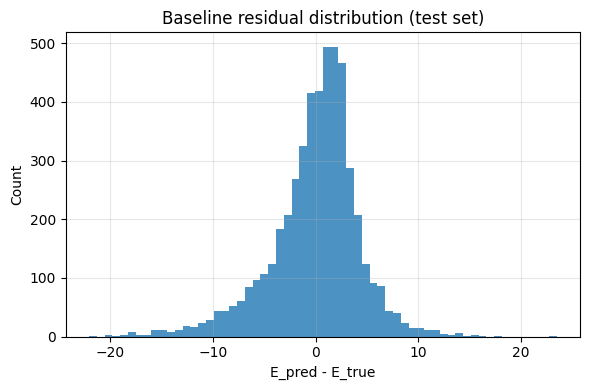

In [12]:
@torch.no_grad()
def predict(model, loader, device="cpu"):
    model.eval()
    preds, truth = [], []
    for tokens, mask, y in loader:
        tokens = tokens.to(device)
        mask   = mask.to(device)
        p = model(tokens, mask).detach().cpu().numpy()
        preds.append(p)
        truth.append(y.numpy())
    return np.concatenate(preds), np.concatenate(truth)

baseline2 = SumCalibBaseline().to(device)
baseline2.load_state_dict(torch.load(baseline_path, map_location="cpu"))

E_pred_b, E_true = predict(baseline2, test_loader, device=device)
print("Test predictions:", E_pred_b.shape, "Truth:", E_true.shape)

corr = np.corrcoef(E_true, E_pred_b)[0, 1]
print("Correlation(E_true, E_pred_baseline) =", corr)

residual = E_pred_b - E_true

plt.figure(figsize=(6,4))
plt.hist(residual, bins=60, alpha=0.8)
plt.xlabel("E_pred - E_true")
plt.ylabel("Count")
plt.title("Baseline residual distribution (test set)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Transformer Regressor

In [13]:
TRANSFORMER_CFG = {
    "d_model": 96,
    "n_heads": 4,
    "n_layers": 3,
    "dropout": 0.1,
    "mlp_ratio": 4,
    "pooling": "cls",   
}

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [14]:
class TokenEmbed(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1):
        super().__init__()
        self.coord_mlp = nn.Sequential(
            nn.Linear(2, d_model),
            nn.GELU(),
            nn.Linear(d_model, d_model),
        )
        self.energy_mlp = nn.Sequential(
            nn.Linear(2, d_model),
            nn.GELU(),
            nn.Linear(d_model, d_model),
        )
        self.norm = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, tokens):
        xy = tokens[..., 0:2]      # (B, K, 2)
        le = tokens[..., 2:4]      # (B, K, 2)  [log_e, e]
        x = self.coord_mlp(xy) + self.energy_mlp(le)
        x = self.drop(self.norm(x))
        return x

In [15]:
class TransformerRegressor(nn.Module):
    def __init__(
        self,
        d_model=96,
        n_heads=4,
        n_layers=3,
        dropout=0.1,
        mlp_ratio=4,
        pooling="cls",
    ):
        super().__init__()
        self.pooling = pooling
        self.embed = TokenEmbed(d_model=d_model, dropout=dropout)

        if pooling == "cls":
            self.cls = nn.Parameter(torch.zeros(1, 1, d_model))
            nn.init.normal_(self.cls, std=0.02)
        else:
            self.cls = None

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=int(d_model * mlp_ratio),
            dropout=dropout,
            activation="gelu",
            batch_first=True,
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1),
        )

    def forward(self, tokens, mask):
        x = self.embed(tokens)         
        pad_mask = ~mask               

        if self.pooling == "cls":
            B = x.size(0)
            cls = self.cls.expand(B, -1, -1)         # (B, 1, D)
            x = torch.cat([cls, x], dim=1)           # (B, 1+K, D)

            cls_pad = torch.zeros((B, 1), device=pad_mask.device, dtype=pad_mask.dtype)
            pad_mask = torch.cat([cls_pad, pad_mask], dim=1)  # (B, 1+K)

        x = self.encoder(x, src_key_padding_mask=pad_mask)

        if self.pooling == "cls":
            pooled = x[:, 0]  # CLS token output
        else:
            # Masked mean over valid tokens
            m = mask.to(x.dtype).unsqueeze(-1)       # (B, K, 1)
            pooled = (x * m).sum(dim=1) / m.sum(dim=1).clamp_min(1.0)

        y = self.head(pooled).squeeze(-1)  # (B,)
        return y

In [16]:
loss_fn = nn.MSELoss()

def run_epoch_transformer(model, loader, optimizer=None, device="cpu", use_amp=True):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device=="cuda"))
    t0 = time.time()
    losses = []

    for tokens, mask, y in loader:
        tokens = tokens.to(device, non_blocking=True)
        mask   = mask.to(device, non_blocking=True)
        y      = y.to(device, non_blocking=True)

        if is_train:
            optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(use_amp and device=="cuda")):
            pred = model(tokens, mask)
            loss = loss_fn(pred, y)

        if is_train:
            scaler.scale(loss).backward()
            # gradient clipping helps stability
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()

        losses.append(loss.detach().float().cpu().item())

    return float(np.mean(losses)), (time.time() - t0)


In [17]:
transformer = TransformerRegressor(**TRANSFORMER_CFG).to(device)

print("Model parameters:", sum(p.numel() for p in transformer.parameters() if p.requires_grad))

Model parameters: 364609


C:\Users\prachinandi\AppData\Roaming\Python\Python313\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [18]:
lr = 3e-4
weight_decay = 1e-2

optimizer = torch.optim.AdamW(transformer.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-5)

In [19]:
EPOCHS = 15             
USE_AMP = True     

best_val = float("inf")
best_state = None

history = {
    "train_loss": [],
    "val_loss": [],
    "epoch_time_s": [],
}

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_time = run_epoch_transformer(transformer, train_loader, optimizer=optimizer, device=device, use_amp=USE_AMP)
    va_loss, va_time = run_epoch_transformer(transformer, val_loader, optimizer=None, device=device, use_amp=USE_AMP)

    scheduler.step()

    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["epoch_time_s"].append(tr_time + va_time)

    if va_loss < best_val:
        best_val = va_loss
        best_state = {k: v.detach().cpu().clone() for k, v in transformer.state_dict().items()}

    current_lr = optimizer.param_groups[0]["lr"]
    print(f"[Transformer] epoch {epoch:02d}/{EPOCHS} | lr={current_lr:.2e} | train={tr_loss:.6f} | val={va_loss:.6f} | best={best_val:.6f}")

C:\Users\prachinandi\AppData\Local\Temp\ipykernel_34136\851787961.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device=="cuda"))
C:\Users\prachinandi\AppData\Local\Temp\ipykernel_34136\851787961.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(use_amp and device=="cuda")):


[Transformer] epoch 01/15 | lr=2.97e-04 | train=12603.127645 | val=11677.319922 | best=11677.319922
[Transformer] epoch 02/15 | lr=2.87e-04 | train=10648.135619 | val=9437.145947 | best=9437.145947
[Transformer] epoch 03/15 | lr=2.72e-04 | train=8206.881805 | val=6886.811792 | best=6886.811792
[Transformer] epoch 04/15 | lr=2.52e-04 | train=5756.693094 | val=4648.096252 | best=4648.096252
[Transformer] epoch 05/15 | lr=2.27e-04 | train=3538.142142 | val=2288.676294 | best=2288.676294
[Transformer] epoch 06/15 | lr=2.00e-04 | train=1628.004763 | val=972.649402 | best=972.649402
[Transformer] epoch 07/15 | lr=1.70e-04 | train=646.199547 | val=325.677448 | best=325.677448
[Transformer] epoch 08/15 | lr=1.40e-04 | train=241.174231 | val=143.240784 | best=143.240784
[Transformer] epoch 09/15 | lr=1.10e-04 | train=105.913894 | val=39.921621 | best=39.921621
[Transformer] epoch 10/15 | lr=8.25e-05 | train=68.956469 | val=35.404263 | best=35.404263
[Transformer] epoch 11/15 | lr=5.80e-05 | tra

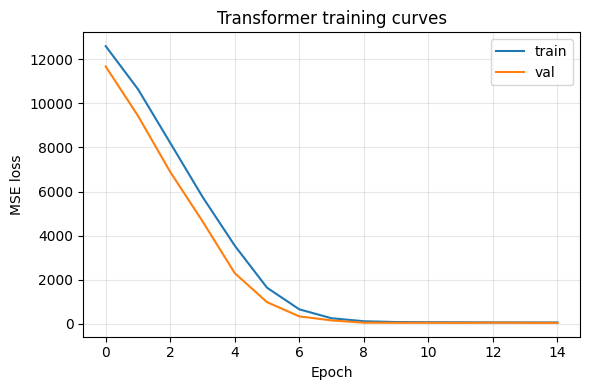

In [20]:
transformer_path = os.path.join(MODELS_DIR, "transformer.pt")
torch.save(best_state, transformer_path)

history_path = os.path.join(RESULTS_DIR, "metrics", "training_history_transformer.json")
with open(history_path, "w") as f:
    json.dump(history, f, indent=2)


plt.figure(figsize=(6,4))
plt.plot(history["train_loss"], label="train")
plt.plot(history["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Transformer training curves")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()